In [18]:
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime

In [19]:
df = pd.read_csv("audio_features_and_popularity_scores_new.csv")
df.columns

Index(['artist_names', 'track_name', 'uri', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'popularity_score1',
       'popularity_score2', 'streams', 'release_week', 'weeks_after_release',
       'occurence_percentage', 'log_occurence', 'normalized_streams',
       'popularity_score_log', 'popularity_log_normalized'],
      dtype='object')

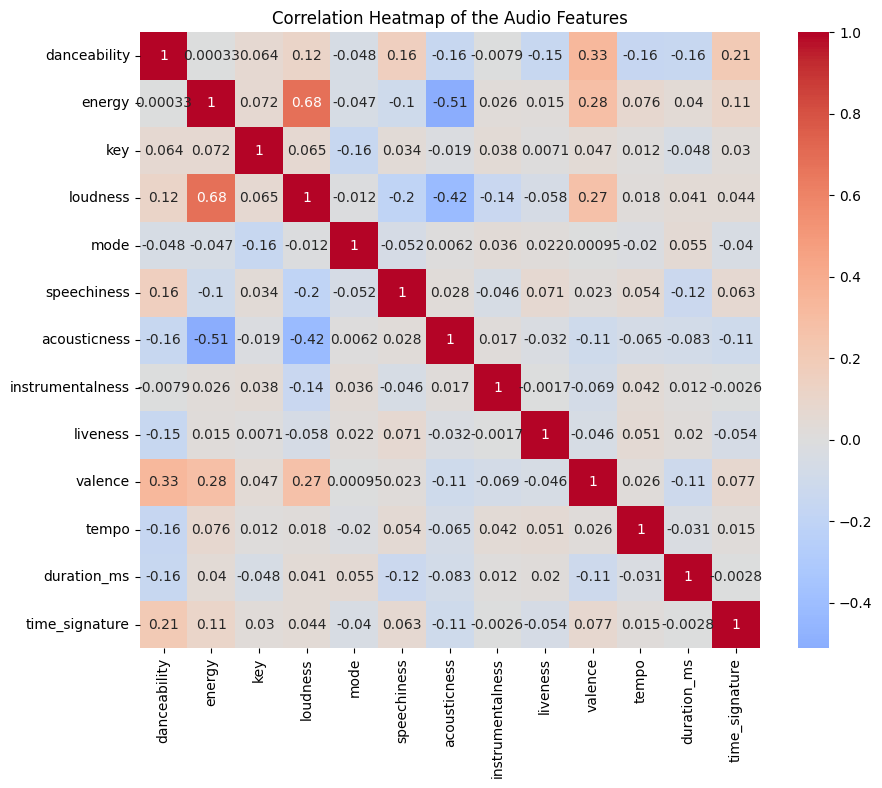

In [20]:
df_audio_features = df[['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']]

corr_matrix = df_audio_features.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

# Display the heatmap
plt.title('Correlation Heatmap of the Audio Features')
plt.show()

In [21]:
df

,artist_names,track_name,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,popularity_score1,popularity_score2,streams,release_week,weeks_after_release,occurence_percentage,log_occurence,normalized_streams,popularity_score_log,popularity_log_normalized
0,Bagossy Brothers Company,Olyan Ő,spotify:track:0VTjzV78c7fn1uo1ApOSkg,0.775,0.510,5,-6.043,1,0.0303,0.18500,...,0.032332,0.079022,278,2019-01-24,286,97.202797,4.576799,0.007064,-2.230590,76.220257
1,Eminem,Without Me,spotify:track:7lQ8MOhq6IN2w8EYcFNSUk,0.908,0.669,7,-2.827,1,0.0738,0.00286,...,0.017148,0.041411,260,2019-01-03,289,89.965398,4.499425,0.003811,-2.876767,57.163727
2,"Dzsúdló, Lil Frakk",Lej,spotify:track:4FATnhRDq5PbfkZMafDuxb,0.790,0.503,1,-9.301,1,0.2060,0.52700,...,0.033573,0.079480,233,2019-11-21,243,95.884774,4.563147,0.007357,-2.224807,76.390781
3,Halott Pénz,Amikor Feladnád,spotify:track:5pZDYdwuEWlCT2Rs7mNyvW,0.737,0.810,1,-3.683,1,0.0772,0.03910,...,0.022289,0.052514,227,2019-04-04,276,82.246377,4.409719,0.005055,-2.639228,64.169023
4,The Weeknd,Blinding Lights,spotify:track:0sf12qNH5qcw8qpgymFOqD,0.512,0.796,1,-4.075,1,0.0645,0.00147,...,0.039152,0.092093,225,2019-12-05,241,93.360996,4.536474,0.008631,-2.077515,80.734601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,Zara Larsson,Lush Life,spotify:track:1rIKgCH4H52lrvDcz50hS8,0.694,0.712,7,-3.923,0,0.0460,0.13200,...,0.008465,0.009956,15,2019-01-03,289,5.190311,1.646794,0.005141,-4.302130,15.128069
1010,Zara Larsson,Ruin My Life,spotify:track:5tAa8Uaqr4VvA3693mbIhU,0.665,0.699,11,-5.265,1,0.0578,0.42300,...,0.007710,0.009067,15,2019-01-03,289,5.190311,1.646794,0.004682,-4.395631,12.370633
1011,"BERRY, T. Danny",Vámpír,spotify:track:3W0Nlg1cO7ZY56vye5VV8E,0.797,0.663,5,-6.968,1,0.0376,0.76800,...,0.012308,0.014475,15,2022-10-27,90,16.666667,2.813411,0.004375,-3.927861,26.165697
1012,Justin Bieber,Hold On,spotify:track:4u4NyuceXP7Uzh7XFJKCr1,0.658,0.634,1,-5.797,0,0.0413,0.01060,...,0.012978,0.015264,15,2021-03-11,175,8.571429,2.148434,0.006041,-3.874838,27.729428


In [26]:
from sklearn.metrics.pairwise import euclidean_distances

def find_closest_song(row, df, selected_features):
    # Calculate the Euclidean distances based on the selected features
    distances = euclidean_distances([row[selected_features]], df[selected_features])[0]
    
    # Remove the distance to itself by setting it to a large number
    distances[df.index == row.name] = np.inf
    
    # Find the index of the closest song
    closest_index = distances.argmin()
    
    return df.loc[closest_index, 'popularity_log_normalized']

def evaluate_subset(df, subset):
    total_difference = 0
    for i, row in df.iterrows():
        closest_popularity = find_closest_song(row, df, subset)
        total_difference += np.abs(row['popularity_log_normalized'] - closest_popularity)
    return total_difference

evaluate_subset(df, ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']), evaluate_subset(df, ['danceability', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo'])

(21852.08663372356, 21654.764901085822)

In [28]:
2**13, 350**2

(8192, 122500)

There are all together 13 features which would mean 2**13 = 8192 subsets and hence 8192 * 2 = 16384 seconds to evaluate all subsets. This runtime is unfeasible. We need another method to find the best subset (one which can also set the weights algorithmically).

# Fitting regression models and inspecting the coefficients

In [32]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances

features = ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
X = df[features]
y = df['popularity_log_normalized']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)

# Extract the coefficients
coefficients = lasso.coef_

coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Filter out the non-zero coefficients
selected_features_df = coefficients_df[coefficients_df['Coefficient'] != 0]

# Order the selected features by the absolute value of their coefficients
selected_features_df['AbsCoefficient'] = selected_features_df['Coefficient'].abs()
selected_features_df = selected_features_df.sort_values(by='AbsCoefficient', ascending=False)

selected_features_df

,Feature,Coefficient,AbsCoefficient
7,instrumentalness,-2.173949,2.173949
3,loudness,-2.062105,2.062105
0,danceability,1.932427,1.932427
1,energy,1.396684,1.396684
11,duration_ms,-1.356025,1.356025
4,mode,-1.020391,1.020391
2,key,-0.563847,0.563847
6,acousticness,0.536747,0.536747
5,speechiness,0.489727,0.489727
12,time_signature,-0.321095,0.321095


In [33]:
import statsmodels.api as sm

features = ['danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
X = df[features]
y = df['popularity_log_normalized']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the Lasso regression model
lasso = Lasso(alpha=0.1)
lasso.fit(X_scaled, y)

# Extract the coefficients
coefficients = lasso.coef_

# Select non-zero coefficients (selected features)
selected_features = [features[i] for i in range(len(features)) if coefficients[i] != 0]

# Create a new DataFrame with only the selected features
X_selected = df[selected_features]

# Add a constant to the model (intercept)
X_selected = sm.add_constant(X_selected)

# Fit an OLS model using statsmodels
ols_model = sm.OLS(y, X_selected).fit()

# Print the summary of the OLS model
print(ols_model.summary())

                                OLS Regression Results                               
Dep. Variable:     popularity_log_normalized   R-squared:                       0.050
Model:                                   OLS   Adj. R-squared:                  0.037
Method:                        Least Squares   F-statistic:                     4.013
Date:                       Mon, 29 Jul 2024   Prob (F-statistic):           1.90e-06
Time:                               10:58:55   Log-Likelihood:                -4378.7
No. Observations:                       1014   AIC:                             8785.
Df Residuals:                           1000   BIC:                             8854.
Df Model:                                 13                                         
Covariance Type:                   nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [41]:
p_values = ols_model.pvalues
features = p_values.index
p_vals = p_values.values
pval_df = pd.DataFrame({"feature" : features, "p_val" : p_vals})
pval_df[pval_df["p_val"] < 0.05]

,feature,p_val
0,const,0.005741
1,danceability,0.001772
2,energy,0.034660
4,loudness,0.003857
8,instrumentalness,0.000094
12,duration_ms,0.018138
